# **Project 2 - Genetic Algorithm for Image Reconstruction.**
**Subject:** MC906/MO416 - Introduction to Artificial Intelligence 

**Authors:**

    Eduardo Barros Innarelli        - RA 170161
    Victor Ferreira Ferrari         - RA 187890
    Vinicius Couto Espindola        - RA 188115

## Introduction
### Project
The project consists of a study of genetic algorithm-based solutions for **image reconstruction**. A few set aspects of the problem will be explained, implemented and discussed here, such as:

- The **modeling** of the problem as an evolutionary problem (chromosomes, genes, etc);
- How to **generate the initial population**;
- The chosen **fitness function**;
- How to **visualize** the result.

Along with that, some aspects of the genetic algorithm will be tested and discussed with multiple approaches, such as:

- Stop criteria;
- Selection technique;
- Crossover technique;
- Mutation technique;
- Generation replacement method.

Also, the following **parameters** will be tested with multiple values as well:
- Population size;
- Mutation rate;
- Crossover rate.

In the end, different variations of the process will be compared and discussed.

### Usage

This project uses the external libraries _OpenCV_ for image reading and manipulation, _NumPy_ for array manipulation, and _MatPlotLib_ for result visualization. The other imports are part of the Standard Python Library.

In [76]:
# External Libraries
from matplotlib import pyplot as plt
import numpy as np
import cv2

# Python Libraries
from random import randint

## Problem
### General Information
The problem consists of, given an image, recreate it from scratch, using the original image only for fitness purposes, to check the similarity between our image and the original. This is not particularly useful in many applications, but can be used as basis for other problems, and is good for the purpose of this project: test different methods of reproduction, mutation, etc.

The motivation came from [Roger Johansson's "Evolution of Mona Lisa"](https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/), but instead of using polygons, the pixel values are directly used.

### Modeling
The modeling of the problem as a GA problem is almost direct. The image is the individual, is the chromosome. Each pixel of the image is a gene. The image can be represented by a multitude of different ways. The chosen way of representation is as a flat array, and this allows for easier operations, especially crossover.

### Inputs
Due to the huge number of combinations in an image (255 possiblities per pixel), greyscale images are used in this project. Low-resolution images are best for this, but there are methods of reducing the resolution using _OpenCV_.

## Methods

### Notes on Structure

The code was organized in such a manner which allows us to first define every method used as well as discuss then in separated modules making each part more readable and comprehesible.

In order to merge all this components of the code we created a class called GeneticAlgorithm. This class retains some essential variables for the methods define along the report, in order to allow the methods to access these variables even though they are not a part of the class, every single method must receive as it's first parameter the class instance, prepended into every parameter list.

### Population Initialization

The first step to run a genetic algorithm is creating a population to serve as a starting point for the selection, reproduction and mutation process. 

Every method in this section will be subdued by the following parameters:
 1. **pop_size:** Defines the maximum amount of individuals for the population.
 2. **gene_count:** Defines how many genes each individual has (genes are pixels in this case).

The following code defines some methods which will be used to create a population out of nothing.

In [123]:
def random(pop_size):
    pop = []
    for i in range(pop_size):
        print(f"Generating Population...  {i:>3}/{pop_size}\r", end='')
        person = [randint(0,255) for i in range(self.goal.size)]
        person = np.asarray(person, dtype=np.uint8)
        pop.append(person)
    print(f"{' '*50}\r", end='')
    return pop

In [79]:
def heuristic(pop_size, gene_count):
    pass

### Fitness Function

For each individual, we must determine a method which will tell us how apt such individual for the problem in question.

The following methods define some method to evaluate how close is an individual to the image we seek to generate.

In [80]:
def fitness(state):
     pass

### Halting Criteria

The algothm cannot run forever. In this section will define two methods used for halting the exection. 
 - The first is our convergence check, which relates to the improvement rate of each generation: if the new generations are not improving when compared to it's antecessors, we consider it a convergence. 
 - The second, is a simple fail safe for the scenario where the convergence is too slow. 

In [81]:
def convergence():
    pass

In [82]:
def abort():
    pass

### Selection Criteria

In this section we'll define methods responsible for selecting individual of the population responsible for bearing the next generation.

Every method in this section will be subdued by the following parameters:
 1. **P:** Defines the probability of accepting a certain idividual.
 2. **N:** Amount of individuals to be selected for the next generation.
 3. **K:** Amount of individuals to partake in a competition.
 
The following code defines some methods which will be used to select individual for the creation of the next generation.

In [83]:
def competition(P, N, K):
    pass

In [84]:
def roulette(P, N, K):
    pass

### Reproduction Method

Reproduction will ensure that the select individuals can exchange genes, preserving some genetic diversity for the next generation.

Every method in this section will be subdued by the following parameters:
 1. **K:** Amount of crossover points for gene exchange.
 
The following code defines some methods which will be used for reproduction creating new for the creation of the next generation.

In [91]:
def crosspoint(K):
    pass

### Mutation Method

To simply permute the genes of the previous generation might reduce the diversity among individuals by creating childs which are too similar to their parents. To counter this we'll use mutation methods allowing genes to mix within individuals. 

Every method in this section will be subdued by the following parameters:
 1. **MR:** Mutation rate dictates the probability of an individual to mutate.
 2. **MA:** Mutation amount defines the amount of genes which will mutate.
 
The following code defines some methods which will be used to mutate the individuals.

In [86]:
def flip(MR, MA):
    pass

In [87]:
def swap(MR, MA):
    pass

## Genetic Algorithm Class

The class will be responsible for selecting which methods will be used for each of the methods in each of the algorithms steps, as well as define it's parameters and executing the main loop. The main loop will be responsible for properly calling the methods, any in between tasks as wells as check halting conditions and picking the fittest individual found in all generations.

##### Preprocessing and Visualization Method
To perceive empirically if the quality of each generation as well as the final result, we will use openCV to exhibit the image represented by some individual.

In [153]:
class GeneticAlgorithm():
    def __init__(self, fit=None, init=None, halt=None, select=None, reprod=None, mutate=None):
        # Goal related variables
        self.shape = None
        self.goal  = None
        
        # Genetic Methods Functions
        define = lambda x: lambda: x[0](self,*x[1]) if x[0] else None
        self.fit    = define(fit)
        self.init   = define(init)
        self.halt   = define(halt)
        self.select = define(select)
        self.reprod = define(reprod)
        self.mutate = define(mutate)
        
        test = [self.fit,self.init,self.select,self.reprod,self.mutate]
        test = all(map(bool, test))
        assert test, "There are undefined steps for the algorithm"
        
#     def run(self, filename):
#         goal = self.read()
#         pop = gen_initial_population(POP_SIZE)
    
#         # Fitness
#         fit = []
#         for i in pop:
#             fit.append(fitness(i))
#         fit = np.array(fit)

#         # Best
#         best_idx = np.argmax(fit)
#         best_sol = pop[best_idx]
#         best_val = fit[best_idx]

#         # Stop criteria
#         sol_val = np.arange(N).sum()
#         iterations = 0

#         while best_val < sol_val and iterations < MAX_ITER:

#             # Roulette selection
#             sel = selection(pop, fit, POP_SIZE)

#             # Reproduction
#             for i in range(0, len(sel), 2):
#                 pop[i], pop[i+1] = reproduction(sel[i], sel[i+1])

#             # Mutation
#             mutate_pop(pop, MUT_RATE)

#             # Fitness
#             for i in range(POP_SIZE):
#                 fit[i] = fitness(pop[i])

#             # Update Max
#             best_idx = np.argmax(fit)
#             if fit[best_idx] > best_val:
#                 best_sol = pop[best_idx]
#                 best_val = fit[best_idx]

#             iterations += 1

#         # Board
#         board = create_board(best_sol)
#         print(board)

#         print('Solution: ', best_sol)
#         print('Iterations: ', iterations)
#         print('Solution Value: ', best_val)
    
    def read(self, filepath, res=None):
        '''Reads an image in grey scale, resizes it and extends to array.
            Params:
                filepath - Path to the input image to be read
                res - Either tuple with new pixel dimensions or ratio with new scale
            Return: 
                np.array - array with the streched image
        '''
        img = cv2.imread(filepath,0) # load in greyscale
        
        if res and tuple==type(res):
            img = cv2.resize(img, res)
        elif res and float==type(res):
            w = int(img.shape[0]*res)
            h = int(img.shape[1]*res)
            img = cv2.resize(img, (h,w))
        print(img.shape)
        self.shape = img.shape # keep shape
        self.goal  = img.reshape(img.size)

    def show(self, individual, compare=False):
        '''Prints the image represented by an individual.
            Params:
                individual - Np.array to be reshaped and printed
        '''
        # If compare mode, print goal along side
        if compare: 
            plt.subplot(1,2,1)
            goal = self.goal.copy()
            goal = goal.reshape(self.shape)
            plt.imshow(goal, cmap='gray')
            plt.title('Goal')
            plt.axis('off')
            plt.subplot(1,2,2)
            
        img = individual.copy()
        img = img.reshape(self.shape)
        plt.imshow(img, cmap='gray')
        plt.title('Individual')
        plt.axis('off')
        plt.show()
    

(577, 480)


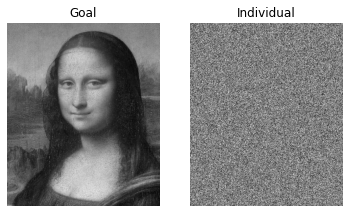

In [155]:
ga = GeneticAlgorithm(
    fit    = (fitness,[None]), 
    init   = (random,[1]), 
    halt   = (convergence,[None]),
    select = (roulette,[None]), 
    reprod = (crosspoint,[None]), 
    mutate = (swap,[None])
    )
ga.read('images\monalisa.jpg', res=0.6)
ga.show(ga.init()[0], compare=True)